In [1]:
import sklearn
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from functools import partial

In [2]:
# df = pd.read_csv("../../data/usa_covid.csv")
df = pd.read_csv("../../data/usa_covid_gt20.csv")
#date
df['date'] = pd.to_datetime(df['date'])

#remove unrelated features
df = df.drop(columns=['aggregation_level','latitude','longitude','openstreetmap_id','location_geometry','datacommons_id','wikidata_id','iso_3166_1_alpha_2','iso_3166_1_alpha_3'])

#drop country and per state rows
df = df.dropna(axis='index', subset=['subregion2_code'])

#remove location names and make map
df = df.astype({'subregion2_code':int})
names = df[['subregion1_name','subregion2_name','subregion2_code']].drop_duplicates(subset=['subregion2_code'])
def codeNameConverter(code, names):
    if isinstance(code, str):
        code = int(code.split("_")[2])
    res = names[names['subregion2_code'] == code]
    return f"{res.iloc[0]['subregion2_name']}, {res.iloc[0]['subregion1_name']}"
codeToName = partial(codeNameConverter, names=names)
df = df.drop(columns=['country_code', 'country_name','subregion1_code','subregion1_name','subregion2_code','subregion2_name'])



In [3]:
#imputations!
#assume nan for rain and snow means 0
df['rainfall_mm'].fillna(0,inplace=True)
df['snowfall_mm'].fillna(0,inplace=True)

#interpolate missing temperatures, can't remove as there are some days with covid cases
df['average_temperature_celsius'] = df['average_temperature_celsius'].interpolate()
df['minimum_temperature_celsius'] = df['minimum_temperature_celsius'].interpolate()
df['maximum_temperature_celsius'] = df['maximum_temperature_celsius'].interpolate()

#drop columns with too many nan (that we couldnt impute)
df = df.dropna(thresh=len(df)*.3,axis=1)

#fill mobility reports with 0 for na since its a relative % to baseline
df['mobility_transit_stations'] = df['mobility_transit_stations'].interpolate()
df['mobility_retail_and_recreation'] = df['mobility_retail_and_recreation'].interpolate()
df['mobility_grocery_and_pharmacy'] = df['mobility_grocery_and_pharmacy'].interpolate()
df['mobility_residential'] = df['mobility_residential'].interpolate()
df['mobility_parks'] = df['mobility_parks'].interpolate()
df['mobility_workplaces	'] = df['mobility_workplaces'].interpolate()

df = df.fillna(0)

In [4]:
df.describe()

,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,mobility_transit_stations,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_residential,mobility_workplaces,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,mobility_workplaces\t
count,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000,67414.000000
mean,93.401949,2.385929,7444.198965,262.083514,-20.806131,-17.186356,-3.469576,48.259983,9.764374,-30.634942,21.400438,15.995837,27.749548,2.221404,0.112914,-32.138272
std,192.657838,8.705259,15933.885491,654.127227,24.944441,17.063103,11.732419,66.066321,6.474565,15.424173,6.563780,6.998424,6.700793,5.437107,2.459830,13.853273
min,21.000000,-512.000000,24.000000,0.000000,-89.000000,-98.000000,-96.000000,-90.000000,-43.000000,-89.000000,-8.383333,-14.067901,-4.238889,0.000000,0.000000,-89.000000
25%,29.000000,0.000000,1114.000000,18.000000,-39.000000,-26.000000,-10.000000,0.230769,5.000000,-40.000000,17.300000,11.222222,23.952353,0.000000,0.000000,-41.000000
50%,45.000000,0.000000,2798.000000,59.000000,-21.000000,-14.000000,-3.857143,37.723636,9.000000,-32.000000,23.022222,17.294444,29.395062,0.056444,0.000000,-32.000000
75%,86.000000,2.000000,7424.750000,197.750000,-3.000000,-6.310884,3.000000,84.248651,13.000000,-20.000000,26.395062,21.777778,32.534722,1.834444,0.000000,-23.000000
max,14129.000000,455.000000,282982.000000,6773.000000,134.000000,188.000000,225.000000,658.000000,38.000000,33.000000,39.833333,32.550000,47.534722,117.202857,149.860000,33.000000


In [5]:
df.count()

date                              67414
location_key                      67414
new_confirmed                     67414
new_deceased                      67414
cumulative_confirmed              67414
cumulative_deceased               67414
mobility_transit_stations         67414
mobility_retail_and_recreation    67414
mobility_grocery_and_pharmacy     67414
mobility_parks                    67414
mobility_residential              67414
mobility_workplaces               67414
average_temperature_celsius       67414
minimum_temperature_celsius       67414
maximum_temperature_celsius       67414
rainfall_mm                       67414
snowfall_mm                       67414
mobility_workplaces\t             67414
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67414 entries, 0 to 78111
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            67414 non-null  datetime64[ns]
 1   location_key                    67414 non-null  object        
 2   new_confirmed                   67414 non-null  int64         
 3   new_deceased                    67414 non-null  float64       
 4   cumulative_confirmed            67414 non-null  int64         
 5   cumulative_deceased             67414 non-null  float64       
 6   mobility_transit_stations       67414 non-null  float64       
 7   mobility_retail_and_recreation  67414 non-null  float64       
 8   mobility_grocery_and_pharmacy   67414 non-null  float64       
 9   mobility_parks                  67414 non-null  float64       
 10  mobility_residential            67414 non-null  float64       
 11  mo

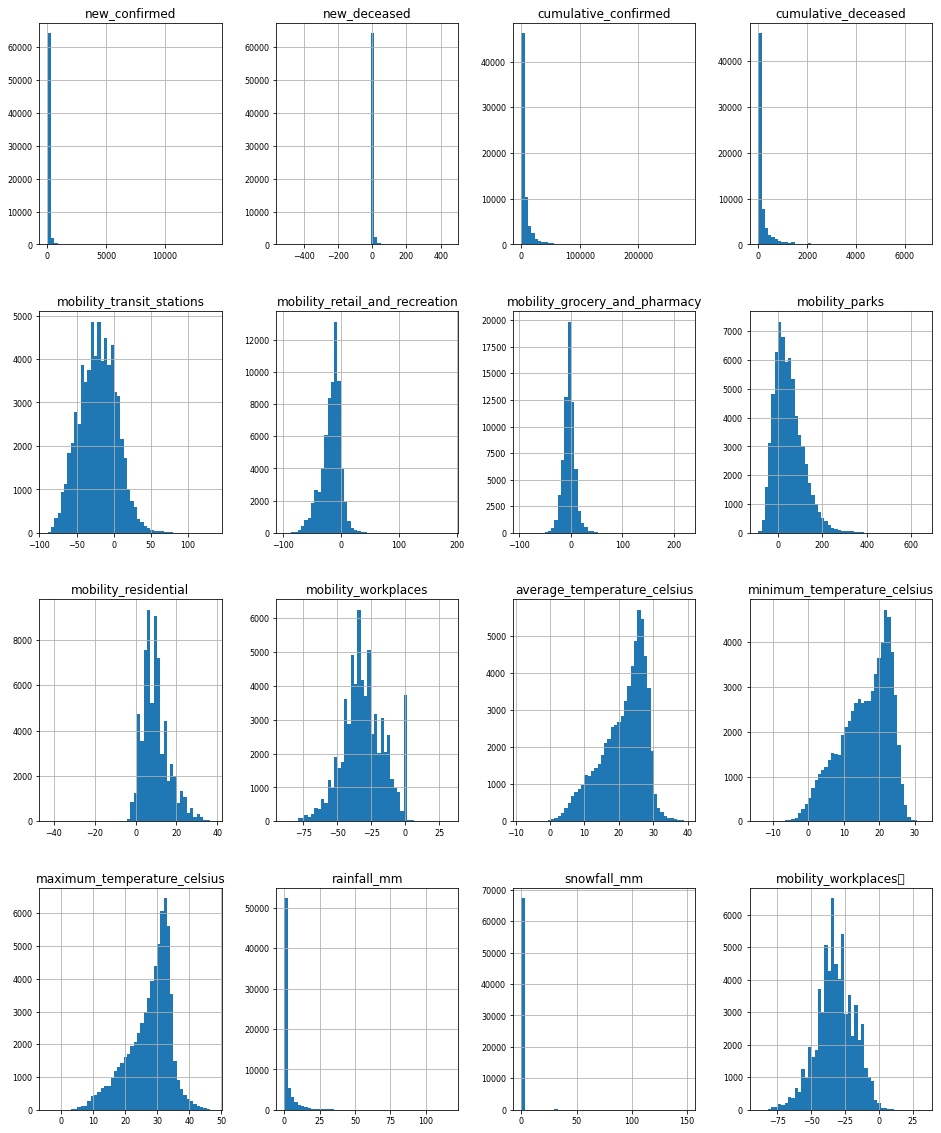

In [7]:
#basic eda
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # ; avoid having the matplotlib verbose informations


In [8]:
# # #corellation avec shift par i jour
# for i in range(20):
#     df_sub = df_num[['mobility_transit_stations','mobility_retail_and_recreation','mobility_grocery_and_pharmacy']]
#     df_sub = df_sub.shift(i,axis=0,fill_value=0)
#     df_shift = pd.concat([df_num['new_confirmed'],df_sub],axis=1)
#     df_shift_corr = df_shift.corr()['new_confirmed']
#     print(df_shift_corr[1:])

In [9]:
# for i in range(0, len(df_num.columns), 5):
#     sns.pairplot(data=df_num,
#                 x_vars=df_num.columns[i:i+5],
#                 y_vars=['new_confirmed'])

In [10]:
# corr = df_num.corr()
# plt.figure(figsize=(12, 10))

# sns.heatmap(corr, 
#             cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
#             annot=True, annot_kws={"size": 8}, square=True)